In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from PyAstronomy import pyasl

import seaborn as sns
from matplotlib import rcParams

import astropy
import dateutil.parser

rcParams.update({'font.size': 25})

In [2]:
##
# used to format the eph data on the sun
#
def parse_large(file):
    eph = open(file, 'r')
    eph_l = list()
    eph_l_2 = list()
    eph_l_3 = list()
    eph_l_4 = list()
    time_list = list()
    
    for i in eph.readlines():
        eph_l.append(i.rstrip())
        
    SOE = False #getting just values and dates from file
    for i in eph_l:
        if i == '$$EOE':
            SOE = False
        if SOE == True:
            eph_l_2.append(i)
        if i == '$$SOE':
            SOE = True
    
    for i in eph_l_2:
        eph_l_3.append([j for j in i.split()][2:])
        time_list.append(i.split()[0])

    for i in range(len(eph_l_3)):
        temp1 = [eph_l_3[i][j:j+3] for j in range(0, len(eph_l_3[i]), 3)] 
        
        temp1_ra = temp1[0]
        temp1_dec = temp1[1]
        
        #make into skycoord readable string
        ra = str(temp1_ra[0]) + 'h' + str(temp1_ra[1]) + 'm' + str(temp1_ra[2]) + 's'
        dec = str(temp1_dec[0]) + 'd' + str(temp1_dec[1]) + 'm' + str(temp1_ra[2]) + 's'
         
        #convert using skycoord
        coord = SkyCoord(ra, dec, frame='icrs')
        
        eph_l_4.append((time_list[i], coord.ra.degree, coord.dec.degree))
        
        
    """
    for i in eph_l_3:
        sublist = list()
        a = i.split(',')
        a = ''.join(a)
        a = a.split(' ')
        for x in a:
            try:
                #remove some annoying equal signs
                if x[0] == "=":
                    x = x[1:]
                
                if x.isdigit and float(x) > 10000:
                    b = x
                if x.isdigit and float(x) < 10000:
                    sublist.append(float(x))
            except:
                True
        
        eph_dict[b] = sublist
    """
    eph.close()
    return eph_l_4

In [8]:
#importing the brown dwarf in
candidate_stars = ascii.read('apjsaaf6aft4_ascii.txt', format='tab')
candidate_stars.keep_columns(['(1)', '(2)', '(4)', '(6)', '(8)', '(9)'])

candidate_stars.rename_column('(1)', 'object_name')
candidate_stars.rename_column('(2)', 'J2000_ra')
candidate_stars.rename_column('(4)', 'J2000_dec')
candidate_stars.rename_column('(6)', 'pi_abs')
candidate_stars.rename_column('(8)', 'mu_ra')
candidate_stars.rename_column('(9)', 'mu_dec')

#keep rows with stars with nearby ephemerides
#needs copy to preserve length of table in for loop
candidate_stars_2 = candidate_stars.copy()
#need different list because .index() cannot do masked columns -- adds lots of unfortunate complexity
candidate_stars_2_o = list(candidate_stars_2['object_name'])
for i in candidate_stars['object_name']:
    if i != 'WISE 0855-0714':
        obj_index = candidate_stars_2_o.index(i)
        candidate_stars_2.remove_row(obj_index)
        candidate_stars_2_o.remove(i)
candidate_stars = candidate_stars_2
        
#importing the path lists in and keeping to 2022
path_list_0855 = pd.read_csv('0855-0714_path.csv')
#path_list_0855 = path_list_0855.head(25)

In [10]:
#importing sun's ra and dec in and processing
sun_eph = parse_large('sun_ephemerides_0855.txt')

sun_eph_cut = list()
for i in sun_eph:
    dt = dateutil.parser.parse(i[0])
    time = astropy.time.Time(dt)
    time_formatted = time.jd
    
    if 2458848.5 <= time_formatted <= 2462498.5:
        time_formatted = time.byear
        sun_eph_cut.append((time_formatted, i[1], i[2]))
sun_eph = sun_eph_cut

sun_df = pd.DataFrame(sun_eph, columns = ['Time', 'RA', 'Dec'])

In [26]:
path_list_0855

,Time,RA,Dec
0,2019.995893,133.773426,-7.243300
1,2019.998631,133.773420,-7.243299
2,2020.001369,133.773414,-7.243299
3,2020.004107,133.773407,-7.243298
4,2020.006845,133.773401,-7.243298
5,2020.009582,133.773395,-7.243297
6,2020.012320,133.773389,-7.243297
7,2020.015058,133.773382,-7.243296
8,2020.017796,133.773376,-7.243295
9,2020.020534,133.773370,-7.243295


In [28]:
#cutting the path lists of brown dwarf and sun to 2020-2023
path_list_0855 = path_list_0855.head(732)
sun_df = sun_df.head(732)

In [33]:
#checking when the dwarf and sun are within the unobservable region
theta_array = list()

below_s_array = list()
below_e_array = list()
for i in range(len(sun_df['RA'])):
    theta = pyasl.getAngDist(list(sun_df['RA'])[i], list(sun_df['Dec'])[i], list(path_list_0855['RA'])[i], list(path_list_0855['Dec'])[i])
    
    if i < len(sun_df['RA']) - 1:
        theta_next = pyasl.getAngDist(list(sun_df['RA'])[i+1], list(sun_df['Dec'])[i+1], list(path_list_0855['RA'])[i+1], list(path_list_0855['Dec'])[i+1])
    if i > 0:
        theta_prev = pyasl.getAngDist(list(sun_df['RA'])[i-1], list(sun_df['Dec'])[i-1], list(path_list_0855['RA'])[i-1], list(path_list_0855['Dec'])[i-1])
    
    #the time when it is unobservable
    sun_radius = 0.2621 #degrees
    hst_unob_r = 35 #degrees
    
    try:
        if theta < (sun_radius + hst_unob_r) and theta_next < (sun_radius + hst_unob_r) and theta_prev > (sun_radius + hst_unob_r):
            below_s_array.append(list(path_list_0855['Time'])[i])
        if theta < (sun_radius + hst_unob_r) and theta_next > (sun_radius + hst_unob_r) and theta_prev < (sun_radius + hst_unob_r):
            below_e_array.append(list(path_list_0855['Time'])[i])
    except:
        continue
            
    theta_array.append(theta)

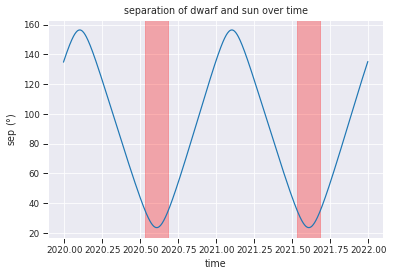

In [40]:
#plotting time
with sns.axes_style('darkgrid', {'xtick.bottom': True, 'ytick.left': True}):
    sns.set_context('paper')
    
    plt.axvspan(below_s_array[0], below_e_array[0], color='red', alpha=0.3)
    plt.axvspan(below_s_array[1], below_e_array[1], color='red', alpha=0.3)
    
    plt.plot(path_list_0855['Time'], theta_array)
    
    plt.xlabel('time')
    plt.ylabel('sep ($ \degree $)')
    plt.title('separation of dwarf and sun over time')
    
    plt.savefig(r'C:\\Users\\judah\\' + 'sun_dwarf_sep')

In [41]:
below_s_array

[2020.5325119780969, 2021.5345653661875]

In [42]:
below_e_array

[2020.6830937713892, 2021.68514715948]